# A List of jobs in this notebook

<br>

Prepare question encodings Qimg x 512, Qtxt x 512

Prepare snippet encodings 540K x 512

Prepare image encodings 390K x 512

<br>

Matrix multiplications: Qimg x 540K, Qimg x 390K, Qtxt x 540K, Qtxt x 390K
Select and rank topk: Qimgx540K_top2000_i, Qimgx390K_top2000_i, Qtxtx540K_top2000_i, Qtxtx390K_top2000_i

<br>

Some plots showing that question-img similarities are systematically lower than question-snippet similarities

<br>

Compute Recall curve (recall@[2, 10, 20, 50, 100, ... 2000]) for zero-shot full-scale CLIP dense retrieval.

Compute retrieval F1 for CLIP's top2

Write to eval.ai submission files for CLIP's top2

<br>

Write to pred_dataset files for 1. having VLP filter rerank CLIP's top20, 2. having VLP QA run on CLIP's top2

<br>

After getting VLP's reranking of CLIP's top20, 1. compute retrieval F1 for CLIP(20)-->VLP(2), 2. write to pred_dataset files for QA

In [1]:
from tqdm import tqdm
import json, random, time, os, base64, copy
import clip, pickle
import numpy as np
from pprint import pprint
from io import BytesIO
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(precision=4) 
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torch

In [8]:
data_dir = "/home/yingshac/CYS/WebQnA/WebQnA_data_new/"
large_matrices_dir = "/data/yingshac/WebQA/large_matrices/CLIP_retrieval"

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/16", device=device)

In [3]:
clip.available_models()

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']

In [3]:
#dataset = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/WebQA_train_val.json", "r"))
dataset = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/WebQA_0904_concat_newimgid_newguid.json", "r"))
print(Counter([dataset[k]['split'] for k in dataset]))
print(len(set([dataset[k]['Guid'] for k in dataset])))
print(Counter([dataset[k]['Qcate'] for k in dataset]))


Counter({'train': 36766, 'test': 7540, 'val': 4966})
49272
Counter({'text': 24343, 'YesNo': 8255, 'Others': 6470, 'choose': 5201, 'number': 2318, 'color': 2058, 'shape': 627})


In [4]:
# Read val_imgguid2qid, val_txtguid2qid
val_imgguid2qid = pickle.load(open(os.path.join(data_dir, "CLIP_retrieval_experiments/val_imgguid2qid.pkl"), "rb"))
val_txtguid2qid = pickle.load(open(os.path.join(data_dir, "CLIP_retrieval_experiments/val_txtguid2qid.pkl"), "rb"))

val_txtqid2guid = {i:guid for guid, i in val_txtguid2qid.items()}
val_imgqid2guid = {i:guid for guid, i in val_imgguid2qid.items()}

print(len(val_imgqid2guid), len(val_txtqid2guid), val_imgqid2guid[999], val_txtqid2guid[888])

2511 2455 d5c268120dba11ecb1e81171463288e9 d5d378000dba11ecb1e81171463288e9


In [15]:
### Generate question encodings for val
### Generate Qimg x 512 matrix
rows = []
bs = 512
batched_ids = []
num_bs = len(val_imgqid2guid)//bs
for j in tqdm(range(num_bs)):
    batched_ids = list(range(j*bs, j*bs+bs))
    text_input = clip.tokenize([dataset[val_imgqid2guid[i]]['Q'] for i in batched_ids], truncate=True).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_input)
    rows.append(text_features)
if not len(val_imgqid2guid) % bs == 0:
    batched_ids = list(range(num_bs*bs, len(val_imgqid2guid)))
    text_input = clip.tokenize([dataset[val_imgqid2guid[i]]['Q'] for i in batched_ids], truncate=True).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_input)
    rows.append(text_features)

Qimgx512 = torch.cat(rows)
print(Qimgx512.size())
torch.save(Qimgx512, os.path.join(data_dir, "CLIP_retrieval_experiments/Qimgx512_val.pt"))

### Generate Qtxt x 512 matrix
rows = []
bs = 512
batched_ids = []
num_bs = len(val_txtqid2guid)//bs
for j in tqdm(range(num_bs)):
    batched_ids = list(range(j*bs, j*bs+bs))
    text_input = clip.tokenize([dataset[val_txtqid2guid[i]]['Q'] for i in batched_ids], truncate=True).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_input)
    rows.append(text_features)
if not len(val_txtqid2guid) % bs == 0:
    batched_ids = list(range(num_bs*bs, len(val_txtqid2guid)))
    text_input = clip.tokenize([dataset[val_txtqid2guid[i]]['Q'] for i in batched_ids], truncate=True).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_input)
    rows.append(text_features)

Qtxtx512 = torch.cat(rows)
print(Qtxtx512.size())
torch.save(Qtxtx512, os.path.join(data_dir, "CLIP_retrieval_experiments/Qtxtx512_val.pt"))

100%|██████████| 4/4 [00:01<00:00,  3.20it/s]


torch.Size([2511, 512])


In [4]:
# Read test_imgguid2qid, test_txtguid2qid
test_imgguid2qid = pickle.load(open(os.path.join(data_dir, "CLIP_retrieval_experiments/test_imgguid2qid.pkl"), "rb"))
test_txtguid2qid = pickle.load(open(os.path.join(data_dir, "CLIP_retrieval_experiments/test_txtguid2qid.pkl"), "rb"))

test_txtqid2guid = {i:guid for guid, i in test_txtguid2qid.items()}
test_imgqid2guid = {i:guid for guid, i in test_imgguid2qid.items()}

print(len(test_imgqid2guid), len(test_txtqid2guid), test_imgqid2guid[999], test_txtqid2guid[888])

3464 4076 d5bf18600dba11ecb1e81171463288e9 d5de3fec0dba11ecb1e81171463288e9


In [6]:
### Generate question encodings for test
### Generate Qimg x 512 matrix
rows = []
bs = 512
batched_ids = []
num_bs = len(test_imgqid2guid)//bs
for j in tqdm(range(num_bs)):
    batched_ids = list(range(j*bs, j*bs+bs))
    text_input = clip.tokenize([dataset[test_imgqid2guid[i]]['Q'] for i in batched_ids], truncate=True).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_input)
    rows.append(text_features)
if not len(test_imgqid2guid) % bs == 0:
    batched_ids = list(range(num_bs*bs, len(test_imgqid2guid)))
    text_input = clip.tokenize([dataset[test_imgqid2guid[i]]['Q'] for i in batched_ids], truncate=True).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_input)
    rows.append(text_features)

Qimgx512 = torch.cat(rows)
print(Qimgx512.size())
torch.save(Qimgx512, os.path.join(data_dir, "CLIP_retrieval_experiments/Qimgx512_test.pt"))

### Generate Qtxt x 512 matrix
rows = []
bs = 512
batched_ids = []
num_bs = len(test_txtqid2guid)//bs
for j in tqdm(range(num_bs)):
    batched_ids = list(range(j*bs, j*bs+bs))
    text_input = clip.tokenize([dataset[test_txtqid2guid[i]]['Q'] for i in batched_ids], truncate=True).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_input)
    rows.append(text_features)
if not len(test_txtqid2guid) % bs == 0:
    batched_ids = list(range(num_bs*bs, len(test_txtqid2guid)))
    text_input = clip.tokenize([dataset[test_txtqid2guid[i]]['Q'] for i in batched_ids], truncate=True).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_input)
    rows.append(text_features)

Qtxtx512 = torch.cat(rows)
print(Qtxtx512.size())
torch.save(Qtxtx512, os.path.join(large_matrices_dir, "Qtxtx512_test.pt"))

100%|██████████| 6/6 [00:03<00:00,  1.89it/s]


torch.Size([3464, 512])


100%|██████████| 7/7 [00:02<00:00,  2.55it/s]


torch.Size([4076, 512])


In [5]:
# Read fact2uniid
fact2uniid = pickle.load(open(os.path.join(data_dir, "CLIP_retrieval_experiments/fact2uniid.pkl"), "rb"))
uniid2fact = {i:fact for fact, i in fact2uniid.items()}
print(len(uniid2fact), uniid2fact[199999])

544489 Fauns are a peculiar, chimeric race: half goat, half human. With horns, hairy legs, hooves, and a twitchy tail, they might not sound like the loveliest characters, but they have their own undeniable charm.


In [12]:
### Generate 540k x 512 matrix
rows = []
bs = 128
batched_ids = []
num_bs = len(uniid2fact)//bs
for j in tqdm(range(num_bs)):
    batched_ids = list(range(j*bs, j*bs+bs))
    text_input = clip.tokenize([uniid2fact[i] for i in batched_ids], truncate=True).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_input)
    rows.append(text_features)
if not len(uniid2fact) % bs == 0:
    batched_ids = list(range(num_bs*bs, len(uniid2fact)))
    text_input = clip.tokenize([uniid2fact[i] for i in batched_ids], truncate=True).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_input)
    rows.append(text_features)

T540Kx512 = torch.cat(rows)
print(T540Kx512.size())
torch.save(T540Kx512, os.path.join(data_dir, "CLIP_retrieval_experiments/T540Kx512.pt"))

  5%|▌         | 231/4253 [00:25<07:19,  9.16it/s]


KeyboardInterrupt: 

In [5]:
with open("/data/yingshac/WebQA/base64_0904/imgs.lineidx", "r") as fp_img:
    img_lineidx = [int(i.strip()) for i in fp_img.readlines()]
    print(len(img_lineidx))

389750


In [6]:
def get_image_input(i):
    with open("/data/yingshac/WebQA/base64_0904/imgs.tsv", "r") as fp_img:
        fp_img.seek(img_lineidx[i])
        imgid, img_base64 = fp_img.readline().strip().split('\t')
    image = Image.open(BytesIO(base64.b64decode(img_base64)))
    image_input = preprocess(image)
    return image_input


In [ ]:
### Generate 390k x 512 matrix
rows = []
bs = 512
num_bs = 389750//bs
for j in tqdm(range(111,num_bs)):
    batched_ids = list(range(j*bs, j*bs+bs))
    image_input = torch.tensor(np.stack([get_image_input(i) for i in batched_ids])).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image_input)
    rows.append(image_features)
if not 389750 % bs == 0:
    batched_ids = list(range(num_bs*bs, 389750))
    image_input = torch.tensor(np.stack([get_image_input(i) for i in batched_ids])).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image_input)
    rows.append(image_features)

I390Kx512 = torch.cat(rows)
print(I390Kx512.size())
torch.save(I390Kx512, os.path.join(large_matrices_dir, "I390Kx512.pt"))

## Matrix Multiplication

In [6]:
split = 'test'

In [8]:
### Load CLIP encodings for 390K images, 540K snippets and 5K val/test Queries
I390Kx512 = torch.load(os.path.join(large_matrices_dir, "I390Kx512.pt"))
T540Kx512 = torch.load(os.path.join(large_matrices_dir, "T540Kx512.pt"))
Qtxtx512 = torch.load(os.path.join(large_matrices_dir, "Qtxtx512_{}.pt".format(split)))
Qimgx512 = torch.load(os.path.join(large_matrices_dir, "Qimgx512_{}.pt".format(split)))

print(I390Kx512.size(), T540Kx512.size())
print(Qimgx512.size(), Qtxtx512.size())

torch.Size([389750, 512]) torch.Size([544489, 512])
torch.Size([3464, 512]) torch.Size([4076, 512])


In [9]:
### Normalize encodings
I390Kx512 = I390Kx512 / I390Kx512.norm(dim=1)[:, None]
T540Kx512 = T540Kx512 / T540Kx512.norm(dim=1)[:, None]
Qtxtx512 = Qtxtx512 / Qtxtx512.norm(dim=1)[:, None]
Qimgx512 = Qimgx512 / Qimgx512.norm(dim=1)[:, None]

In [10]:
### Compute 2.5K x 540K
torch.cuda.synchronize()
%time Qtxtx540K = torch.matmul(Qtxtx512.to("cuda"), T540Kx512.to("cuda").t()); torch.cuda.synchronize()
print(Qtxtx540K.size())
torch.save(Qtxtx540K.cpu(), os.path.join(large_matrices_dir, "Qtxtx540K_{}.pt".format(split)))

torch.cuda.synchronize()
%time Qtxtx540K_top2000_i = torch.topk(Qtxtx540K, 2000).indices.cpu(); torch.cuda.synchronize()
%time Qtxtx540K_top2000_v = torch.topk(Qtxtx540K, 2000).values.cpu(); torch.cuda.synchronize()

print(Qtxtx540K_top2000_i.size(), Qtxtx540K_top2000_v.size())
torch.save(Qtxtx540K_top2000_i, os.path.join(large_matrices_dir, "Qtxtx540K_{}_top2000_i.pt".format(split)))
torch.save(Qtxtx540K_top2000_v, os.path.join(large_matrices_dir, "Qtxtx540K_{}_top2000_v.pt".format(split)))

# ------------------------- #
torch.cuda.synchronize()
%time Qimgx540K = torch.matmul(Qimgx512.to("cuda"), T540Kx512.to("cuda").t()); torch.cuda.synchronize()
print(Qimgx540K.size())
torch.save(Qimgx540K.cpu(), os.path.join(large_matrices_dir, "Qimgx540K_{}.pt".format(split)))

torch.cuda.synchronize()
%time Qimgx540K_top2000_i = torch.topk(Qimgx540K, 2000).indices.cpu(); torch.cuda.synchronize()
%time Qimgx540K_top2000_v = torch.topk(Qimgx540K, 2000).values.cpu(); torch.cuda.synchronize()

print(Qimgx540K_top2000_i.size(), Qimgx540K_top2000_v.size())
torch.save(Qimgx540K_top2000_i, os.path.join(large_matrices_dir, "Qimgx540K_{}_top2000_i.pt".format(split)))
torch.save(Qimgx540K_top2000_v, os.path.join(large_matrices_dir, "Qimgx540K_{}_top2000_v.pt".format(split)))

CPU times: user 128 ms, sys: 7.9 ms, total: 136 ms
Wall time: 136 ms
torch.Size([4076, 544489])
CPU times: user 324 ms, sys: 35.4 ms, total: 360 ms
Wall time: 362 ms
CPU times: user 340 ms, sys: 0 ns, total: 340 ms
Wall time: 340 ms
torch.Size([4076, 2000]) torch.Size([4076, 2000])
CPU times: user 124 ms, sys: 3.8 ms, total: 128 ms
Wall time: 131 ms
torch.Size([3464, 544489])
CPU times: user 235 ms, sys: 31.7 ms, total: 267 ms
Wall time: 267 ms
CPU times: user 263 ms, sys: 0 ns, total: 263 ms
Wall time: 262 ms
torch.Size([3464, 2000]) torch.Size([3464, 2000])


In [11]:
### Compute 2.5K x 390K
torch.cuda.synchronize()
%time Qtxtx390K = torch.matmul(Qtxtx512.to("cuda"), I390Kx512.to("cuda").t()); torch.cuda.synchronize()
print(Qtxtx390K.size())
torch.save(Qtxtx390K.cpu(), os.path.join(large_matrices_dir, "Qtxtx390K_{}.pt".format(split)))

torch.cuda.synchronize()
%time Qtxtx390K_top2000_i = torch.topk(Qtxtx390K, 2000).indices.cpu(); torch.cuda.synchronize()
%time Qtxtx390K_top2000_v = torch.topk(Qtxtx390K, 2000).values.cpu(); torch.cuda.synchronize()

print(Qtxtx390K_top2000_i.size(), Qtxtx390K_top2000_v.size())
torch.save(Qtxtx390K_top2000_i, os.path.join(large_matrices_dir, "Qtxtx390K_{}_top2000_i.pt".format(split)))
torch.save(Qtxtx390K_top2000_v, os.path.join(large_matrices_dir, "Qtxtx390K_{}_top2000_v.pt".format(split)))

# ------------------------- #
torch.cuda.synchronize()
%time Qimgx390K = torch.matmul(Qimgx512.to("cuda"), I390Kx512.to("cuda").t()); torch.cuda.synchronize()
print(Qimgx390K.size())
torch.save(Qimgx390K.cpu(), os.path.join(large_matrices_dir, "Qimgx390K_{}.pt".format(split)))

torch.cuda.synchronize()
%time Qimgx390K_top2000_i = torch.topk(Qimgx390K, 2000).indices.cpu(); torch.cuda.synchronize()
%time Qimgx390K_top2000_v = torch.topk(Qimgx390K, 2000).values.cpu(); torch.cuda.synchronize()

print(Qimgx390K_top2000_i.size(), Qimgx390K_top2000_v.size())
torch.save(Qimgx390K_top2000_i, os.path.join(large_matrices_dir, "Qimgx390K_{}_top2000_i.pt".format(split)))
torch.save(Qimgx390K_top2000_v, os.path.join(large_matrices_dir, "Qimgx390K_{}_top2000_v.pt".format(split)))

CPU times: user 70.5 ms, sys: 875 µs, total: 71.4 ms
Wall time: 72.7 ms
torch.Size([4076, 389750])
CPU times: user 248 ms, sys: 36 ms, total: 284 ms
Wall time: 285 ms
CPU times: user 193 ms, sys: 271 µs, total: 194 ms
Wall time: 194 ms
torch.Size([4076, 2000]) torch.Size([4076, 2000])
CPU times: user 27.8 ms, sys: 3.87 ms, total: 31.7 ms
Wall time: 31.9 ms
torch.Size([3464, 389750])
CPU times: user 122 ms, sys: 24.7 ms, total: 146 ms
Wall time: 146 ms
CPU times: user 113 ms, sys: 0 ns, total: 113 ms
Wall time: 113 ms
torch.Size([3464, 2000]) torch.Size([3464, 2000])


In [9]:
## Load top2000 indices and values
Qimgx390K_top2000_i = torch.load(os.path.join(large_matrices_dir, "Qimgx390K_{}_top2000_i.pt".format(split)))
Qimgx390K_top2000_v = torch.load(os.path.join(large_matrices_dir, "Qimgx390K_{}_top2000_v.pt".format(split)))
Qimgx540K_top2000_i = torch.load(os.path.join(large_matrices_dir, "Qimgx540K_{}_top2000_i.pt".format(split)))
Qimgx540K_top2000_v = torch.load(os.path.join(large_matrices_dir, "Qimgx540K_{}_top2000_v.pt".format(split)))
Qtxtx390K_top2000_i = torch.load(os.path.join(large_matrices_dir, "Qtxtx390K_{}_top2000_i.pt".format(split)))
Qtxtx390K_top2000_v = torch.load(os.path.join(large_matrices_dir, "Qtxtx390K_{}_top2000_v.pt".format(split)))
Qtxtx540K_top2000_i = torch.load(os.path.join(large_matrices_dir, "Qtxtx540K_{}_top2000_i.pt".format(split)))
Qtxtx540K_top2000_v = torch.load(os.path.join(large_matrices_dir, "Qtxtx540K_{}_top2000_v.pt".format(split)))


This is a text query


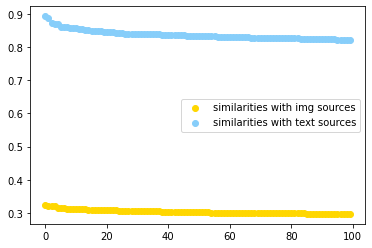

In [40]:
j = random.choice(list(range(2511+2455)))
if j >= 2511:
    print("This is a text query")
    y1 = Qtxtx390K_top100_v[j-2511]
    y2 = Qtxtx540K_top100_v[j-2511]
else:
    print("This is an img query")
    y1 = Qimgx390K_top100_v[j]
    y2 = Qimgx540K_top100_v[j]

x = list(range(100)) 
plt.scatter(x, y1, c ="gold", label="similarities with img sources")
plt.scatter(x, y2, c ="lightskyblue", label="similarities with text sources")
plt.legend()
plt.show()

In [41]:
avg_sim_w_img = torch.cat([torch.mean(Qimgx390K_top100_v, 1), torch.mean(Qtxtx390K_top100_v, 1)]).cpu()
print(avg_sim_w_img.size())
avg_sim_w_txt = torch.cat([torch.mean(Qimgx540K_top100_v, 1), torch.mean(Qtxtx540K_top100_v, 1)]).cpu()
print(avg_sim_w_txt.size())


torch.Size([4966])
torch.Size([4966])


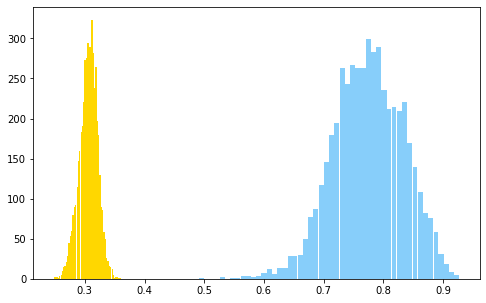

In [43]:
fig = plt.figure(figsize=(8, 5))
plt.hist(list(avg_sim_w_txt), bins=50, color='lightskyblue')
plt.hist(list(avg_sim_w_img), bins=50, color='gold')
plt.show()

torch.Size([2511]) torch.Size([2455])
torch.Size([2511]) torch.Size([2455])


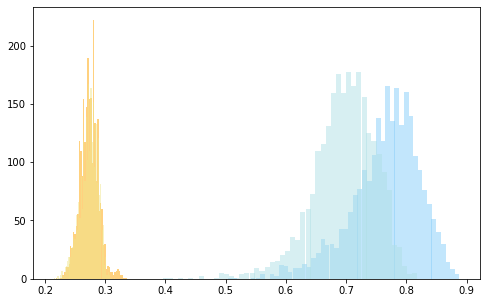

In [5]:
avg_sim_Qimg_w_img = torch.mean(Qimgx390K_top2000_v, 1).cpu()
avg_sim_Qtxt_w_img = torch.mean(Qtxtx390K_top2000_v, 1).cpu()
print(avg_sim_Qimg_w_img.size(), avg_sim_Qtxt_w_img.size())
avg_sim_Qimg_w_txt = torch.mean(Qimgx540K_top2000_v, 1).cpu()
avg_sim_Qtxt_w_txt = torch.mean(Qtxtx540K_top2000_v, 1).cpu()
print(avg_sim_Qimg_w_txt.size(), avg_sim_Qtxt_w_txt.size())

fig = plt.figure(figsize=(8, 5))
plt.hist(list(avg_sim_Qtxt_w_txt), bins=50, alpha = 0.5, color='lightskyblue')
plt.hist(list(avg_sim_Qimg_w_txt), bins=50, alpha = 0.5, color='powderblue')
plt.hist(list(avg_sim_Qimg_w_img), bins=50, alpha = 0.5, color='orange')
plt.hist(list(avg_sim_Qtxt_w_img), bins=50, alpha = 0.5, color='khaki')

plt.show()

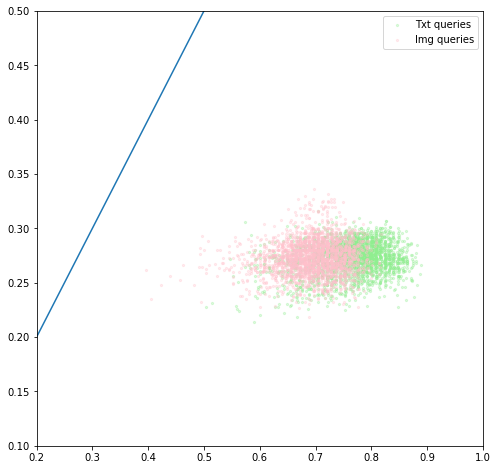

In [6]:
fig = plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], '-')
plt.scatter(list(avg_sim_Qtxt_w_txt), list(avg_sim_Qtxt_w_img), c ="lightgreen", label="Txt queries", alpha=0.3, s=5)
plt.scatter(list(avg_sim_Qimg_w_txt), list(avg_sim_Qimg_w_img), c ="pink", label="Img queries", alpha=0.3, s=5)
plt.legend()
plt.ylim(0.1, 0.5)
plt.xlim(0.2, 1)
plt.show()

## Recall @[2, 10, 20, 50, 100], assuming answer modality is known

In [8]:
def recall(candidate_list, ans_list):
    # Arguments are sets of integers
    intersection = ans_list.intersection(candidate_list)
    return len(intersection)/len(ans_list)
        

In [9]:
def compute_retrieval_metrics(pred, gth):

    common = len(set(pred).intersection(gth))
    RE = common / (len(gth)) 
    PR = common / (len(pred)) # No protection against division by zero because it's assumed that CLIP never gives empty output
    F1 = 2*PR*RE / (PR + RE + 1e-5)
    return F1, RE, PR

In [10]:
### Load val/test Retrieval_answers
imgRetrievalAns = pickle.load(open(os.path.join(data_dir, "CLIP_retrieval_experiments/{}_imgRetrievalAns.pkl".format(split)), "rb"))
txtRetrievalAns = pickle.load(open(os.path.join(data_dir, "CLIP_retrieval_experiments/{}_txtRetrievalAns.pkl".format(split)), "rb"))

In [11]:
K = [2, 10, 20, 50, 100, 200, 500, 1000, 2000]
Qimg_scores = defaultdict(float)
Qtxt_scores = defaultdict(float)
for k in K:
    Qimg_scores[k] = np.mean([recall(set(Qimgx390K_top2000_i[i][:k].numpy()), set(imgRetrievalAns[i])) for i in range(len(imgRetrievalAns))])
    Qtxt_scores[k] = np.mean([recall(set(Qtxtx540K_top2000_i[i][:k].numpy()), set(txtRetrievalAns[i])) for i in range(len(txtRetrievalAns))])
print("Recall@k img queries:")
pprint(Qimg_scores)
print("Recall@k txt queries:")
pprint(Qtxt_scores)

Recall@k img queries:
defaultdict(<class 'float'>,
            {2: 0.12947459584295612,
             10: 0.30153002309468824,
             20: 0.3895785219399538,
             50: 0.5225173210161663,
             100: 0.6251443418013857,
             200: 0.7126154734411085,
             500: 0.8091801385681293,
             1000: 0.8670612009237876,
             2000: 0.913539260969977})
Recall@k txt queries:
defaultdict(<class 'float'>,
            {2: 0.1392500817795224,
             10: 0.2610606804056264,
             20: 0.3154440628066732,
             50: 0.38442508995747465,
             100: 0.4362528622832843,
             200: 0.4878148511612692,
             500: 0.5573683349689238,
             1000: 0.6023470722930979,
             2000: 0.6440137389597644})


In [12]:
K = [2, 10, 20, 50, 100, 200, 500, 1000, 2000]
Qimg_scores = defaultdict(float)
Qtxt_scores = defaultdict(float)
for k in K:
    Qimg_scores[k] = np.mean([compute_retrieval_metrics(set(Qimgx390K_top2000_i[i][:k].numpy()), set(imgRetrievalAns[i]))[1] for i in range(len(imgRetrievalAns))])
    Qtxt_scores[k] = np.mean([compute_retrieval_metrics(set(Qtxtx540K_top2000_i[i][:k].numpy()), set(txtRetrievalAns[i]))[1] for i in range(len(txtRetrievalAns))])
print("Recall@k img queries:")
top2_perf = [compute_retrieval_metrics(set(Qimgx390K_top2000_i[i][:2].numpy()), set(imgRetrievalAns[i])) for i in range(len(imgRetrievalAns))]
pprint(Qimg_scores)
print("Top2: F1={:.4f}, RE={:.4f}, PR={:.4f}".format(np.mean([P[0] for P in top2_perf]), np.mean([P[1] for P in top2_perf]), np.mean([P[2] for P in top2_perf]) ))

print("Recall@k txt queries:")
top2_perf = [compute_retrieval_metrics(set(Qtxtx540K_top2000_i[i][:2].numpy()), set(txtRetrievalAns[i])) for i in range(len(txtRetrievalAns))]

pprint(Qtxt_scores)
print("Top2: F1={:.4f}, RE={:.4f}, PR={:.4f}".format(np.mean([P[0] for P in top2_perf]), np.mean([P[1] for P in top2_perf]), np.mean([P[2] for P in top2_perf]) ))


Recall@k img queries:
defaultdict(<class 'float'>,
            {2: 0.12947459584295612,
             10: 0.30153002309468824,
             20: 0.3895785219399538,
             50: 0.5225173210161663,
             100: 0.6251443418013857,
             200: 0.7126154734411085,
             500: 0.8091801385681293,
             1000: 0.8670612009237876,
             2000: 0.913539260969977})
Top2: F1=0.0971, RE=0.1295, PR=0.0810
Recall@k txt queries:
defaultdict(<class 'float'>,
            {2: 0.1392500817795224,
             10: 0.2610606804056264,
             20: 0.3154440628066732,
             50: 0.38442508995747465,
             100: 0.4362528622832843,
             200: 0.4878148511612692,
             500: 0.5573683349689238,
             1000: 0.6023470722930979,
             2000: 0.6440137389597644})
Top2: F1=0.1396, RE=0.1393, PR=0.1403


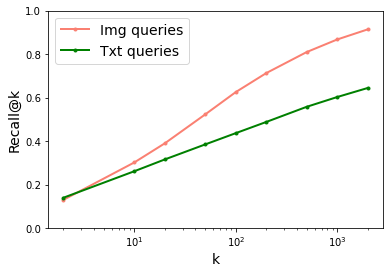

In [24]:
fig = plt.figure(figsize=(6, 4))
plt.plot(list(Qimg_scores.keys()), list(Qimg_scores.values()), '-', marker='.', color='salmon', label='Img queries', linewidth=2)
plt.plot(list(Qtxt_scores.keys()), list(Qtxt_scores.values()), '-', marker='.', color='green', label='Txt queries', linewidth=2)

plt.legend(fontsize=14)
plt.ylim(0, 1)
plt.ylabel('Recall@k', fontsize=14)
plt.xscale('log')
plt.xlabel('k', fontsize=14)
plt.savefig("CLIP_recall_curve.jpg", dpi=250)
plt.show()

In [ ]:
fluency_avg = 0.4695
acc_avg = 0.4533
mul_avg = 0.2479

## Write to pred_dataset_val CLIP top2 as positive and the remaining top20 as negative

In [7]:
### Create imgid2caption 
imgid2caption = {}
for k in tqdm(list(dataset.keys())):
    if dataset[k]['Qcate'] == 'text':
        for im in dataset[k]['img_negFacts']:
            imgid2caption[im['image_id']] = im['caption']
    else:
        for im in dataset[k]['img_posFacts']:
            imgid2caption[im['image_id']] = im['caption']
        for im in dataset[k]['img_negFacts']:
            imgid2caption[im['image_id']] = im['caption']
        
print(len(imgid2caption))
pickle.dump(imgid2caption, open(os.path.join(data_dir, "imgid2caption.pkl"), "wb"))

100%|██████████| 49272/49272 [00:00<00:00, 109211.42it/s]


389750


In [35]:
### load imgid2caption and image_id_map_0904
imgid2caption = pickle.load(open(os.path.join(data_dir, "imgid2caption.pkl"), "rb"))
image_id_map_0904 = pickle.load(open(os.path.join(data_dir, "image_id_map_0904.pkl"), "rb"))
r_image_id_map_0904 = {newid:oldid for oldid, newid in image_id_map_0904.items()}
print(len(imgid2caption), len(image_id_map_0904))

389750 389750


In [25]:
### Write dataset with CLIP retrieval results for val (top2 in the posFacts field, the remaining top20 in the negFacts field)
pred_data = {}
for g in dataset:
    if dataset[g]['split'] == 'val' and not dataset[g]['Qcate'] == 'text':
        pred_data[g] = copy.deepcopy(dataset[g])
        top20_clip_image_ids = Qimgx390K_top2000_i[val_imgguid2qid[g]][:20].numpy().tolist()
        pred_data[g]['img_posFacts'] = []
        for i in top20_clip_image_ids[:2]:
            pred_data[g]['img_posFacts'].append({
                'image_id': r_image_id_map_0904[i+30000000], 
                'caption': imgid2caption[i+30000000]})
        pred_data[g]['img_negFacts'] = []
        for i in top20_clip_image_ids[2:]:
            pred_data[g]['img_negFacts'].append({
                'image_id': r_image_id_map_0904[i+30000000], 
                'caption': imgid2caption[i+30000000]})
        
        top20_clip_text_ids = Qimgx540K_top2000_i[val_imgguid2qid[g]][:20].numpy().tolist()
        pred_data[g]['txt_negFacts'] = []
        for i in top20_clip_text_ids:
            pred_data[g]['txt_negFacts'].append({
                'fact': uniid2fact[i]})
print(len(pred_data))
json.dump(pred_data, open(os.path.join(data_dir, "CLIP_retrieval_experiments/Qimg_clip_retrieval_val.json"), "w"))


2511


In [16]:
### Write dataset with CLIP retrieval results for test (top2 in the posFacts field, the remaining top20 in the negFacts field)
# pred_data for Qimg
pred_data = {}
for g in dataset:
    if dataset[g]['split'] == 'test' and not dataset[g]['Qcate'] == 'text':
        pred_data[g] = copy.deepcopy(dataset[g])
        top20_clip_image_ids = Qimgx390K_top2000_i[test_imgguid2qid[g]][:20].numpy().tolist()
        pred_data[g]['img_posFacts'] = []
        for i in top20_clip_image_ids[:2]:
            pred_data[g]['img_posFacts'].append({
                'image_id': r_image_id_map_0904[i+30000000], 
                'caption': imgid2caption[i+30000000]})
        pred_data[g]['img_negFacts'] = []
        for i in top20_clip_image_ids[2:]:
            pred_data[g]['img_negFacts'].append({
                'image_id': r_image_id_map_0904[i+30000000], 
                'caption': imgid2caption[i+30000000]})
        
        top20_clip_text_ids = Qimgx540K_top2000_i[test_imgguid2qid[g]][:20].numpy().tolist()
        pred_data[g]['txt_negFacts'] = []
        for i in top20_clip_text_ids:
            pred_data[g]['txt_negFacts'].append({
                'fact': uniid2fact[i]})
print(len(pred_data))
json.dump(pred_data, open(os.path.join(data_dir, "CLIP_retrieval_experiments/Qimg_clip_retrieval_test.json"), "w"))

# pred_data for Qtxt
pred_data = {}
for g in dataset:
    if dataset[g]['split'] == 'test' and dataset[g]['Qcate'] == 'text':
        pred_data[g] = copy.deepcopy(dataset[g])
        top20_clip_text_ids = Qtxtx540K_top2000_i[test_txtguid2qid[g]][:20].numpy().tolist()

        # For each txt fact I need to add a 'snippet_id' field for the filter infr to run and calculate scores 
        # Because I need to run VLP filter infr on this predicted dataset for coarse-to-fine filter: CLIP Top20, VLP Top2
        # Note that this snippet_id is different from the one in original dataset
        pred_data[g]['txt_posFacts'] = []
        for i in top20_clip_text_ids[:2]:
            pred_data[g]['txt_posFacts'].append({
                'fact': uniid2fact[i], 
                'snippet_id': i})
        pred_data[g]['txt_negFacts'] = []
        for i in top20_clip_text_ids[2:]:
            pred_data[g]['txt_negFacts'].append({
                'fact': uniid2fact[i],
                'snippet_id': i})
        
        top20_clip_image_ids = Qtxtx390K_top2000_i[test_txtguid2qid[g]][:20].numpy().tolist()
        pred_data[g]['img_negFacts'] = []
        for i in top20_clip_image_ids:
            pred_data[g]['img_negFacts'].append({
                'image_id': r_image_id_map_0904[i+30000000], 
                'caption': imgid2caption[i+30000000]})
print(len(pred_data))
json.dump(pred_data, open(os.path.join(data_dir, "CLIP_retrieval_experiments/Qtxt_clip_retrieval_test.json"), "w"))


3464
4076


In [12]:
## Generate submission files to eval.ai  (CLIP Top2 full-scale retrieval)
evalai_submission_CLIPtop2 = {}
for g in dataset:
    if not dataset[g]['split'] == 'test': continue
    if dataset[g]['Qcate'] == 'text':
        retrieved_snippet_ids = []
        retrieved_facts = []
        for x in Qtxtx540K_top2000_i[test_txtguid2qid[g]][:2].tolist():
            retrieved_facts.append(uniid2fact[x])
        for x in dataset[g]['txt_posFacts']:
            if x['fact'] in retrieved_facts:
                retrieved_snippet_ids.append(x['snippet_id'])
        retrieved_snippet_ids.extend((2-len(retrieved_snippet_ids))*["dummy"])
        evalai_submission_CLIPtop2[g] = {'sources': retrieved_snippet_ids, 'answer': ""}
    else:
        evalai_submission_CLIPtop2[g] = \
            {'sources': [ x+30000000 for x in Qimgx390K_top2000_i[test_imgguid2qid[g]][:2].tolist() ], 
            'answer': ""}

json.dump(evalai_submission_CLIPtop2, open("evalai_submission_CLIPtop2.json", "w"))


##### Decode commands
CUDA_VISIBLE_DEVICES=2 python decode_webqa.py --new_segment_ids --batch_size 32 --answer_provided_by "img" --beam_size 5 --split "test" --num_workers 4 --output_dir light_output/detectron_both_qa_upd --ckpts_dir /data/yingshac/WebQA/ckpts/detectron_both_qa_upd --no_eval --recover_step 11 --img_dataset_json_path /home/yingshac/CYS/WebQnA/WebQnA_data_new/CLIP_retrieval_experiments/Qimg_clip_retrieval_test.json

CUDA_VISIBLE_DEVICES=1 python decode_webqa.py --new_segment_ids --batch_size 32 --answer_provided_by "txt" --beam_size 5 --split "test" --num_workers 4 --output_dir light_output/detectron_both_qa_upd --ckpts_dir /data/yingshac/WebQA/ckpts/detectron_both_qa_upd --no_eval --recover_step 11 --txt_dataset_json_path /home/yingshac/CYS/WebQnA/WebQnA_data_new/CLIP_retrieval_experiments/Qtxt_clip_retrieval_test.json


##### VLP filter on CLIP's top20 (assume known answer modality) commands
CUDA_VISIBLE_DEVICES=3 python run_webqa.py --new_segment_ids --train_batch_size 20 --split test --answer_provided_by 'img' --task_to_learn 'filter' --num_workers 4 --max_pred 10 --mask_prob 1.0 --learning_rate 3e-5 --gradient_accumulation_steps 1 --save_loss_curve --output_dir light_output/filter_both_x_detectron_upd --ckpts_dir /data/yingshac/WebQA/ckpts/filter_both_x_detectron_upd --recover_step 3 --img_filter_max_choices 20 --img_dataset_json_path /home/yingshac/CYS/WebQnA/WebQnA_data_new/CLIP_retrieval_experiments/Qimg_clip_retrieval_test.json

CUDA_VISIBLE_DEVICES=2 python run_webqa.py --new_segment_ids --train_batch_size 20 --split test --answer_provided_by 'txt' --task_to_learn 'filter' --num_workers 4 --max_pred 10 --mask_prob 1.0 --learning_rate 3e-5 --gradient_accumulation_steps 1 --save_loss_curve --output_dir light_output/filter_both_x_detectron_upd --ckpts_dir /data/yingshac/WebQA/ckpts/filter_both_x_detectron_upd --recover_step 3 --txt_filter_max_choices 20 --txt_dataset_json_path /home/yingshac/CYS/WebQnA/WebQnA_data_new/CLIP_retrieval_experiments/Qtxt_clip_retrieval_test.json


In [38]:
### Write dataset with CLIP retrieval Top20 --> VLP Top2 results for test (top2 in the posFacts field, the remaining top20 in the negFacts field)
TH = 0.2
# pred_data for Qimg
VLP_filter_output = json.load(open("/home/yingshac/CYS/WebQnA/VLP/vlp/light_output/filter_both_x_detectron_upd/test_-1_step3_img_20_True_True_Qimg_clip_retrieval_{}.json".format(split), "r"))
print(len(VLP_filter_output))
VLP_top2_reselection = np.full((len(txtRetrievalAns), 2), -1, dtype=np.int32)
for i in range(len(imgRetrievalAns)):
    g = test_imgqid2guid[i]
    vlp_filter_scores = np.array([float(x) for x in VLP_filter_output[g]['pred_scores']])
    top2_idx = np.argsort(vlp_filter_scores)[-2:]
    for j in [0, 1]:
        if j==1 or vlp_filter_scores[top2_idx[j]] >= TH:
            VLP_top2_reselection[i][j] = image_id_map_0904[VLP_filter_output[g]['choices'][top2_idx[j]]] - 30000000

# Score: VLP_top2_reselection vs. retrievalAns
top2_perf = [compute_retrieval_metrics(set(VLP_top2_reselection[i]), set(imgRetrievalAns[i])) for i in range(len(imgRetrievalAns))]
print("VLP reselected top2 from CLIP's top20, image queries: F1={:.4f}, RE={:.4f}, PR={:.4f}".format(np.mean([P[0] for P in top2_perf]), np.mean([P[1] for P in top2_perf]), np.mean([P[2] for P in top2_perf]) ))

# Write dataset (only contain predicted top2 sources in the posFacts field, assuming known answer modality)
pred_data = {}
for g in dataset:
    if dataset[g]['split'] == 'test' and not dataset[g]['Qcate'] == 'text':
        pred_data[g] = copy.deepcopy(dataset[g])
        top20_clip_image_ids = VLP_top2_reselection[test_imgguid2qid[g]].tolist()
        pred_data[g]['img_posFacts'] = []
        for i in top20_clip_image_ids:
            if i < 0: continue
            pred_data[g]['img_posFacts'].append({
                'image_id': r_image_id_map_0904[i+30000000], 
                'caption': imgid2caption[i+30000000]})
        pred_data[g]['img_negFacts'] = []
        pred_data[g]['txt_negFacts'] = []
print(len(pred_data))
json.dump(pred_data, open(os.path.join(data_dir, "CLIP_retrieval_experiments/Qimg_clipvlp_top2_test.json"), "w"))

### ------------------------------------------------------------------------------ ###
# pred_data for Qtxt
VLP_filter_output = json.load(open("/home/yingshac/CYS/WebQnA/VLP/vlp/light_output/filter_both_x_detectron_upd/test_-1_step3_txt_20_True_Qtxt_clip_retrieval_{}.json".format(split), "r"))
print(len(VLP_filter_output))
VLP_top2_reselection = np.full((len(txtRetrievalAns), 2), -1, dtype=np.int32)
for i in range(len(txtRetrievalAns)):
    g = test_txtqid2guid[i]
    vlp_filter_scores = np.array([float(x) for x in VLP_filter_output[g]['pred_scores']])
    top2_idx = np.argsort(vlp_filter_scores)[-2:]
    for j in [0, 1]:
        if j==1 or vlp_filter_scores[top2_idx[j]] >= TH:
            VLP_top2_reselection[i][j] = VLP_filter_output[g]['choices'][top2_idx[j]]

# Score: VLP_top2_reselection vs. retrievalAns
top2_perf = [compute_retrieval_metrics(set(VLP_top2_reselection[i]), set(txtRetrievalAns[i])) for i in range(len(txtRetrievalAns))]
print("VLP reselected top2 from CLIP's top20, text queries: F1={:.4f}, RE={:.4f}, PR={:.4f}".format(np.mean([P[0] for P in top2_perf]), np.mean([P[1] for P in top2_perf]), np.mean([P[2] for P in top2_perf]) ))

# Write dataset (only contain predicted top2 sources in the posFacts field, assuming known answer modality)
pred_data = {}
for g in dataset:
    if dataset[g]['split'] == 'test' and dataset[g]['Qcate'] == 'text':
        pred_data[g] = copy.deepcopy(dataset[g])
        top2_clipvlp_text_ids = VLP_top2_reselection[test_txtguid2qid[g]].tolist()

        pred_data[g]['txt_posFacts'] = []
        for i in top2_clipvlp_text_ids:
            if i < 0: continue
            pred_data[g]['txt_posFacts'].append({
                'fact': uniid2fact[i]})
        pred_data[g]['txt_negFacts'] = []
        pred_data[g]['img_negFacts'] = []
print(len(pred_data))
json.dump(pred_data, open(os.path.join(data_dir, "CLIP_retrieval_experiments/Qtxt_clipvlp_top2_test.json"), "w"))

3464
VLP reselected top2 from CLIP's top20, image queries: F1=0.2168, RE=0.2823, PR=0.1840
3464
4076
VLP reselected top2 from CLIP's top20, text queries: F1=0.2601, RE=0.2593, PR=0.2615
4076


##### Decode commands on pred_datasets with coarse-to-fine retrieval (CLIP top20 --> VLP top2)

CUDA_VISIBLE_DEVICES=2 python decode_webqa.py --new_segment_ids --batch_size 32 --answer_provided_by "img" --beam_size 5 --split "test" --num_workers 4 --output_dir light_output/detectron_both_qa_upd --ckpts_dir /data/yingshac/WebQA/ckpts/detectron_both_qa_upd --no_eval --recover_step 11 --img_dataset_json_path /home/yingshac/CYS/WebQnA/WebQnA_data_new/CLIP_retrieval_experiments/Qimg_clipvlp_top2_test.json

CUDA_VISIBLE_DEVICES=1 python decode_webqa.py --new_segment_ids --batch_size 32 --answer_provided_by "txt" --beam_size 5 --split "test" --num_workers 4 --output_dir light_output/detectron_both_qa_upd --ckpts_dir /data/yingshac/WebQA/ckpts/detectron_both_qa_upd --no_eval --recover_step 11 --txt_dataset_json_path /home/yingshac/CYS/WebQnA/WebQnA_data_new/CLIP_retrieval_experiments/Qtxt_clipvlp_top2_test.json


In [1]:
import numpy as np
x = np.array([5878, 2565, 1896])
y = np.array([3565, 5250, 2942])
(x * 3464 + y * 4076) / (3464+4076)


NameError: name 'np' is not defined